In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from lightgbm import LGBMClassifier
from skopt import gp_minimize, load
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.callbacks import CheckpointSaver
from skopt.plots import plot_convergence
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, roc_curve

In [13]:
%%time
train = pd.read_csv("data/train.csv")
print(train.shape)

(200000, 202)
CPU times: user 6.35 s, sys: 805 ms, total: 7.15 s
Wall time: 7.27 s


In [14]:
%%time
train = pd.read_csv("data/train.csv")
print(train.shape)

(200000, 202)
CPU times: user 5.95 s, sys: 451 ms, total: 6.4 s
Wall time: 6.41 s


In [15]:
features = [f for f in train.columns if f not in ['target', 'ID_code']]

X = train[features]
y = train['target']

In [16]:
space  = [Integer(1, 100, name='n_iter'),
          Integer(1, 10, name='max_depth'),
          Real(0.05, 1, name='colsample_bytree'),
          Real(0.5, 1, name='subsample'),
          Real(0.001, 10, 'log-uniform', name='lambda_l1'),
          Real(0.001, 10, 'log-uniform', name='lambda_l2'),
          Real(0.001, 1, name='min_split_gain')]

In [17]:
param_list = []
for elem in space:
    param_list.append(elem.name)

In [18]:
@use_named_args(space)
def objective(**params):
    
    folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 0)
    features = [f for f in train.columns if f not in ['target', 'ID_code']]
    
    oof_preds = np.zeros(train.shape[0])
    
    scores = []
    
    clf = LGBMClassifier(objective = 'binary',
                         metric = 'auc',
                         random_state = 0,
                         n_thread = 4)
        
    clf.set_params(**params)
    
    for param, value in params.items():
        print(f"{param}: {value}")
    
    for n_fold, (train_index, valid_index) in enumerate(folds.split(train[features], train['target'])):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    
        clf.fit(X_train, y_train, 
              eval_set=[(X_valid, y_valid)], 
              verbose=0, 
              early_stopping_rounds=100)
        
        oof_preds[valid_index] = clf.predict_proba(X_valid, n_iter=clf.best_iteration_)[:, 1]
        
        score = roc_auc_score(y_valid, oof_preds[valid_index])
        scores.append(score)
    
    cv = np.mean(scores)
    print(f"AUC folds: {scores}\n Average AUC: {cv}")
        
    return -cv

In [19]:
checkpoint_saver = CheckpointSaver("./bayesopt_checkpoint.pkl", compress=9) # keyword arguments will be passed to skopt.dump

In [21]:
try:
    res = load('./bayesopt_checkpoint.pkl')

    x_init = res.x_iters
    y_init = res.func_vals
except:
    x_init = None
    y_init = None
finally:
    res_gp = gp_minimize(objective,
                         space,
                         x0 = x_init,
                         y0 = y_init,
                         n_calls=5,
                         n_random_starts = 3,
                         callback = [checkpoint_saver],
                         verbose = True,
                         random_state = 0)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0154
Function value obtained: -0.8871
Current minimum: -0.8954
Iteration No: 2 started. Evaluating function at random point.
n_iter: 593
max_depth: 9
colsample_bytree: 0.8650483367416192
subsample: 0.9236258693920628
lambda_l1: 0.3120719877010644
lambda_l2: 0.03447679044520658
min_split_gain: 0.29823707193792787


/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC folds: [0.8835047473080171, 0.8875957683577738, 0.8902329380626929]
 Average AUC: 0.8871111512428279
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 67.5727
Function value obtained: -0.8871
Current minimum: -0.8954
Iteration No: 3 started. Evaluating function at random point.
n_iter: 58
max_depth: 3
colsample_bytree: 0.5037818614552825
subsample: 0.9060843643877468
lambda_l1: 0.08315889109899302
lambda_l2: 0.03725110709391402
min_split_gain: 0.8362426847738403


/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC folds: [0.8081131192855096, 0.8113257646733818, 0.8161980194744767]
 Average AUC: 0.8118789678111226
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 12.2887
Function value obtained: -0.8119
Current minimum: -0.8954
Iteration No: 4 started. Searching for the next optimal point.
n_iter: 338
max_depth: 7
colsample_bytree: 0.3998294628485206
subsample: 0.9785775794765232
lambda_l1: 0.0036425298685704706
lambda_l2: 3.0223797682839186
min_split_gain: 0.4741344372284369


/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC folds: [0.884620832603259, 0.887647299411701, 0.8895985392851772]
 Average AUC: 0.887288890433379
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 32.4574
Function value obtained: -0.8873
Current minimum: -0.8954
Iteration No: 5 started. Searching for the next optimal point.
n_iter: 860
max_depth: 10
colsample_bytree: 0.37642316400318143
subsample: 0.7009410671835505
lambda_l1: 0.0038381838132045933
lambda_l2: 0.08792295265272206
min_split_gain: 0.7777696747670669


/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC folds: [0.8855603013149301, 0.8891959294335775, 0.8918116413497492]
 Average AUC: 0.8888559573660856
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 47.2745
Function value obtained: -0.8889
Current minimum: -0.8954
n_iter: 806
max_depth: 10
colsample_bytree: 0.3253115430979344
subsample: 0.7585321083478102
lambda_l1: 10.0
lambda_l2: 7.319718765593105
min_split_gain: 0.9574954064921642


/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/marcusahlgren/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC folds: [0.8891357828652894, 0.8927360065451533, 0.8948993972360273]
 Average AUC: 0.89225706221549
Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 87.7410
Function value obtained: -0.8923
Current minimum: -0.8954


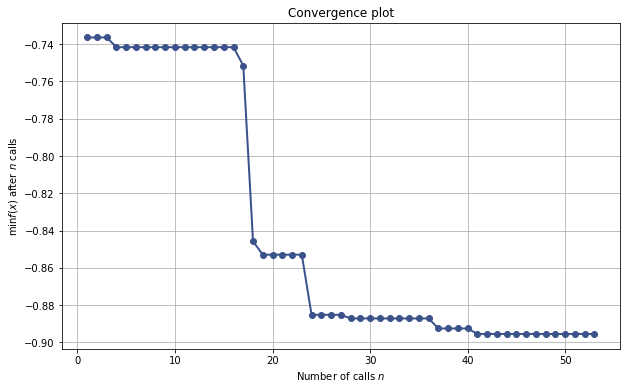

In [22]:
plt.figure(figsize=(10, 6))
plot_convergence(res_gp)
plt.show()

In [29]:
result_df = pd.DataFrame(res_gp.x_iters, columns = param_list)
result_df['CV'] = -res_gp.func_vals
result_df

,n_iter,max_depth,colsample_bytree,subsample,lambda_l1,lambda_l2,min_split_gain,CV
0,6,9,0.865048,0.923626,0.312072,0.034477,0.298237,0.736465
1,2,3,0.503782,0.906084,0.083159,0.037251,0.836243,0.631239
2,6,9,0.859753,0.837843,1.400161,0.150549,0.301149,0.736263
3,6,10,0.748142,0.980718,0.047714,0.006287,0.270242,0.741682
4,1,1,1.000000,0.500000,10.000000,10.000000,0.001000,0.546055
5,6,9,0.865048,0.923626,0.312072,0.034477,0.298237,0.736465
6,2,3,0.503782,0.906084,0.083159,0.037251,0.836243,0.631239
7,5,10,0.171010,0.967337,0.127175,0.001000,0.001000,0.728966
8,10,10,0.050000,1.000000,0.001000,0.001000,0.001000,0.725171
9,1,10,0.050000,0.500000,10.000000,10.000000,1.000000,0.590289


In [30]:
result_df.loc[result_df['CV'].idxmax()]

n_iter              873.000000
max_depth            10.000000
colsample_bytree      0.050000
subsample             0.563154
lambda_l1            10.000000
lambda_l2            10.000000
min_split_gain        1.000000
CV                    0.895449
Name: 40, dtype: float64